Import all the libraries that will be used

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from PIL import Image, ImageOps
import shutil as sh
import random

2024-12-04 08:14:31.401110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733296471.419263    4787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733296471.424155    4787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 08:14:31.441614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Dispositivos disponibles:")
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configura la primera GPU visible
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Usando la GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Dispositivos disponibles:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Usando la GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


This is for fixing the structure of the FooDD dataset

In [ ]:
if os.path.exists("./Datasets/FooDD/"):
    sh.rmtree("./Datasets/FooDD/Mixed")
    sh.rmtree("./Datasets/FooDD/Net images")
    sh.rmtree("./Datasets/FooDD/Grape/3-IOS-4-Light Environment") # This directory has tomato pictures but on the Grape dir. Also, those images are already on the tomato dir, so simply delete it
    sh.move("./Datasets/FooDD/Grape & Apple", "./Datasets/FooDD/Grape_and_Apple")

    # This gets rid of the camera directories
    for dirPath, _, files in os.walk("./Datasets/FooDD/", topdown=False): # Iterates through all the directories of the dataset
        for file in files:
            dst = os.path.join(os.path.dirname(dirPath), file) # Save the destination path for the image (Egg/X/Y.img -> Egg/Y.img)

            if os.path.exists(dst): # Probably no image will trigger this, but there are some images that are named IMG_XXX, so just in case
                name, ext = os.path.splitext(file)
                i = 1
                while os.path.exists(dst): # This loop executing more than once is even less probable, but better safe than sorry
                    dst = os.path.join(os.path.dirname(dirPath), f"{name}_{i}{ext}")
                    i += 1

            sh.move(os.path.join(dirPath, file), dst)

        try:
            os.rmdir(dirPath) # Try deleting the folder (as we moved all the images out)
        except OSError: # If the folder isn't empty, an exception is thrown (Bananas' dirs will be deleted, but not the Banana directory)
            pass

    # Now, separate the images into train and validate sets
    for dirPath, dirNames, files in os.walk("./Datasets/FooDD"):
        if len(files) != 0:
            train_subdir = os.path.join("./Datasets/FooDD/train",  os.path.relpath(dirPath, "./Datasets/FooDD")) # The relPath thing gives the name of the food
            validate_subdir = os.path.join("./Datasets/FooDD/validate",  os.path.relpath(dirPath, "./Datasets/FooDD"))
            os.makedirs(train_subdir, exist_ok=True)
            os.makedirs(validate_subdir, exist_ok=True)

            random.shuffle(files) # shuffles the names so that it won't take the first 70%, but a "random" 70%
            num_train = int(len(files) * 0.7)

            archivos_train = files[:num_train]
            archivos_validate = files[num_train:]

            # Mover archivos
            for file in archivos_train:
                sh.move(os.path.join(dirPath, file), os.path.join(train_subdir, file))
            for file in archivos_validate:
                sh.move(os.path.join(dirPath, file), os.path.join(validate_subdir, file))
            os.rmdir(dirPath) # Delete the empty dirs, as now they are separated into train and validate dirs

This is for fixing the Food-101 structure

In [ ]:
if os.path.exists("./Datasets/food-101/"):
    file = open("./Datasets/food-101/meta/train.txt")
    list = file.readlines()
    file.close()

    for item in list:
        os.makedirs("./Datasets/food-101/images/train/"+item.split("/")[0], exist_ok=True)
        sh.move("./Datasets/food-101/images/"+item[:-1]+".jpg", "./Datasets/food-101/images/train/"+item[:-1]+".jpg")

    file = open("./Datasets/food-101/meta/test.txt")
    list = file.readlines()
    file.close()

    for item in list:
        os.makedirs("./Datasets/food-101/images/validate/"+item.split("/")[0], exist_ok=True)
        sh.move("./Datasets/food-101/images/"+item[:-1]+".jpg", "./Datasets/food-101/images/validate/"+item[:-1]+".jpg")

    for dirPath, _, _ in os.walk("./Datasets/food-101/images/"):
        try:
            os.rmdir(dirPath)
        except:
            pass

Create a dict with the paths of the images that will be used

In [2]:
trainSet = { }
validateSet = { }

totalTrain = 0
totalValidate = 0

def addDir(path: str, train: bool):
    global totalTrain
    global totalValidate
    iterator = os.walk(path)
    dst = ""
    if train:
        dst = "./Datasets/Cleaned/train/" + path.split("/")[-1]
    else:
        dst = "./Datasets/Cleaned/validate/" + path.split("/")[-1]
    for dirPath, _, files in iterator:
        if(len(files) != 0):
            os.makedirs(dst + dirPath.split("/")[-1], exist_ok=True)
            if train:
                trainSet[dirPath] = files
                totalTrain += len(files)
            else:
                validateSet[dirPath] = files
                totalValidate += len(files)

# addDir("./Datasets/Tipical_Brazilian_Foods/train/", True)
# addDir("./Datasets/Tipical_Brazilian_Foods/valid/", False)
# addDir("./Datasets/FooDD/train/", True)
# addDir("./Datasets/FooDD/validate/", False)

addDir("./Datasets/food-101/images/train/", True)
addDir("./Datasets/food-101/images/validate/", False)

print("Total train classes: " + str(len(trainSet.keys())))
print("Total validation classes: " + str(len(validateSet.keys())))
print("Total train images: " + str(totalTrain))
print("Total validation images: " + str(totalValidate))

Total train classes: 101
Total validation classes: 101
Total train images: 75750
Total validation images: 25250


Image preprocessing algorithm

In [3]:
img_size = 128

def preprocess(src: str, train: bool, dst: str = None):
    image = Image.open(src)

    image.thumbnail((img_size, img_size), Image.BICUBIC)
    delta_w = img_size - image.size[0]
    delta_h = img_size - image.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    image = ImageOps.expand(image, padding, fill=(255, 255, 255))

    if image.mode in ("RGBA", "LA"): #If the image has transparency, get rid of it
        background = Image.new("RGB", image.size, (255, 255, 255)) #Create a white image to act as the background
        background.paste(image, mask=image.split()[3]) #Apply this background where there is transparency on the image
        image = background
        
    if dst == None:
        if train:
            dst = "./Datasets/Cleaned/train/" + "/".join(src.split("/")[-2:])
        else:
            dst = "./Datasets/Cleaned/validate/" + "/".join(src.split("/")[-2:])

    if not (dst.endswith(".jpg") or dst.endswith(".jpeg")):
        dst = ".".join(dst.split(".")[:-1]) + ".jpg"
    image.save(dst, "JPEG") 

In [28]:
for key in trainSet.keys():
    for image in trainSet[key]:
        try:
            preprocess(str(key) + "/" + image, True)
        except Exception as e:
            print("ERROR " + str(key) + "/" + image + ": " + str(e))

for key in validateSet.keys():
    for image in validateSet[key]:
        try:
            preprocess(str(key) + "/" + image, False)
        except Exception as e:
            print("ERROR " + str(key) + "/" + image + ": " + str(e))

ERROR ./Datasets/food-101/images/train/steak/1340977.jpg: color must be int or single-element tuple
ERROR ./Datasets/food-101/images/train/bread_pudding/1375816.jpg: color must be int or single-element tuple
ERROR ./Datasets/food-101/images/train/lasagna/3787908.jpg: color must be int or single-element tuple


Quick model

Found 75747 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - accuracy: 0.0281 - loss: 4.4805 - val_accuracy: 0.0863 - val_loss: 4.0405 - learning_rate: 0.0010
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.0731 - loss: 4.1246 - val_accuracy: 0.1168 - val_loss: 3.8347 - learning_rate: 0.0010
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.0998 - loss: 3.9529 - val_accuracy: 0.1499 - val_loss: 3.6586 - learning_rate: 0.0010
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.1204 - loss: 3.8183 - val_accuracy: 0.1626 - val_loss: 3.5581 - learning_rate: 0.0010
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.1350 - loss: 3.7292 - val_accuracy: 0.1673 - val_loss: 3.5237 - learning_rate: 0.0010
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.1417 - loss: 3.6798 - val_accuracy: 0.1806 - val_loss: 3.4749 - learning_rate: 0.0010
Epoch 7/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step -

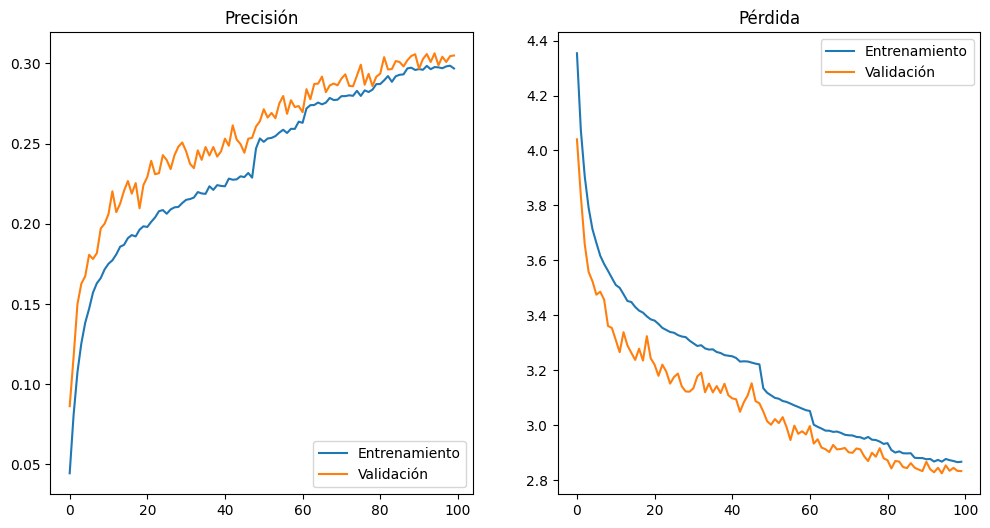

In [6]:
# Configuración
IMG_SIZE = (img_size, img_size)  # Tamaño de las imágenes (ya están preprocesadas)
BATCH_SIZE = 32        # Tamaño del batch
EPOCHS = 100            # Número de épocas

# Directorios de datos
TRAIN_DIR = "./Datasets/Cleaned/train"  # Cambia esto por la ruta a tu carpeta de entrenamiento
VAL_DIR = "./Datasets/Cleaned/validate"  # Cambia esto por la ruta a tu carpeta de validación

# Cargar datasets desde los directorios
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,  # Las imágenes ya deberían tener este tamaño
    batch_size=BATCH_SIZE,
    label_mode="categorical",  # Las clases serán one-hot encoded
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Normalización (si no se hizo en el preprocesamiento)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Aumentación de datos (solo para entrenamiento)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=(0.9, -0.9)),
])

# Construcción del modelo
model = models.Sequential([
    data_augmentation,  # Aumentación para los datos de entrenamiento
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),  # Regularización para prevenir sobreajuste
    layers.Dense(len(trainSet.keys()), activation="softmax")  # cantidad de clases
])

# Compilación del modelo
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Resumen del modelo
model.summary()
# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Métrica a monitorear
    factor=0.5,          # Factor por el que se reduce el learning rate (a la mitad)
    patience=5,          # Número de épocas sin mejora antes de reducir
    min_lr=1e-6          # Límite inferior del learning rate
)
# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[reduce_lr]
)

# Graficar resultados
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Entrenamiento")
    plt.plot(epochs_range, val_acc, label="Validación")
    plt.legend(loc="lower right")
    plt.title("Precisión")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Entrenamiento")
    plt.plot(epochs_range, val_loss, label="Validación")
    plt.legend(loc="upper right")
    plt.title("Pérdida")
    plt.show()

plot_history(history)

In [ ]:

import numpy as np
from tensorflow.keras.preprocessing import image

def predict(path: str):
    # Cargar la imagen y redimensionarla al tamaño que espera el modelo (en este caso 128x128)
    img = image.load_img(path)

    # Convertir la imagen a un array numpy y agregar una dimzensión extra para que sea compatible con el modelo
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Esto convierte la forma de (128, 128, 3) en (1, 128, 128, 3)

    # Normalizar la imagen (si es necesario, según el preprocesamiento que hayas hecho en el entrenamiento)
    img_array = img_array / 255.0  # Normalizar a [0, 1] si lo hiciste en el entrenamiento

    # Hacer la predicción
    predictions = model.predict(img_array)

    print(predictions)
    predicted_class_index = np.argmax(predictions)
    class_names = ["Acaraje", "Apple", "Arroz_com_pequi", "Arroz de cuxa", "Banana", "Barreado", "Bean", "Bread", "Carrot", "Cheese", "Churrasco", "Cucumber", "Egg", "Eisben", "Feijoada", "Grape", "Matrinxa", "Moqueca_capixaba", "Onion", "Orange", "Pao_de_queijo", "Pasta", "Pato_no_Tucupi", "Pepper", "Qiwi", "Sauce", "Tacaca", "Tomato", "Watermelon"]  # Cambia estos nombres por los correctos

    predicted_class = class_names[predicted_class_index]
    print(f"La imagen es de: {predicted_class}")

In [ ]:
preprocess("./Predictions/Raw/1.jpg", False, "./Predictions/Ready/1.jpg")
preprocess("./Predictions/Raw/2.jpg", False, "./Predictions/Ready/2.jpg")
preprocess("./Predictions/Raw/3.jpg", False, "./Predictions/Ready/3.jpg")
preprocess("./Predictions/Raw/4.jpg", False, "./Predictions/Ready/4.jpg")
preprocess("./Predictions/Raw/5.jpg", False, "./Predictions/Ready/5.jpg")
preprocess("./Predictions/Raw/6.jpg", False, "./Predictions/Ready/6.jpg")

predict("./Predictions/Ready/1.jpg")
predict("./Predictions/Ready/2.jpg")
predict("./Predictions/Ready/3.jpg")
predict("./Predictions/Ready/4.jpg")
predict("./Predictions/Ready/5.jpg")
predict("./Predictions/Ready/6.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[[1.00732817e-13 8.06684718e-02 1.04891569e-23 1.05047944e-19
  1.24947450e-28 3.35337928e-17 2.91395481e-25 1.37752391e-21
  4.90884833e-10 1.49144994e-19 6.59206378e-09 1.43394973e-30
  2.22952741e-22 1.62370182e-21 3.84831595e-20 1.11162652e-08
  6.43999316e-29 8.25558715e-23 3.43674155e-17 4.94698465e-01
  7.90033751e-18 1.31856612e-20 6.67763987e-19 1.36512084e-21
  2.09090099e-01 5.41722006e-17 2.05402183e-23 2.15425134e-01
  1.17743082e-04 5.09530480e-08]]
La imagen es de: Orange
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[6.11599096e-12 6.18809164e-02 7.34128802e-16 3.08490958e-14
  1.71374379e-16 1.07547028e-14 4.06493678e-20 2.52023278e-06
  5.33876062e-07 2.23859817e-13 8.56350102e-10 8.10962327e-23
  8.32837177e-09 1.96000340e-16 1.36488755e-17 2.68025026e-02
  6.50278830e-21 3.11607994e-18 2.16144004e-15 8.65503609e-01
  1.05741620e-14 3.00603964e-12 5.21493516e-16 1.60142911e-17
  2.56962283e-03 3.46342677e-10 2.29241923e-17 3.78734693e-